# # of b-tags

**Goal:** Try to understand how the # of b-tags in the training is impacting the shapes that we can learn.

In [33]:
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import gridspec

import json
import time
import h5py
import uproot
import torch

from trainNet import pairAGraph
from preprocess import truthInfo, parallelTruthMatchJets, parallelGetCorrectPair
from preprocess import processDf, scale, applyCuts

import os
os.sys.path.append('../code')
from analysis import fileDir, normalizeWeight
from AnalysisUtils import nanoToDf
from eventDisplays import truthDisplay

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load in the data and concatenate the dfs.**

In [20]:
dat_dfs = {}
reload = False

In [34]:
fileDir['data16_PFlow-FEB20']

'/u/ki/nhartman/gpfs/public/hh4b/data/user.mswiatlo.HH4B.period*.data16..AB21.2.91-FEB20-0.pflow_vr_MiniNTuple.root/'

In [36]:
len(glob(fileDir['data16_PFlow-FEB20']+'*.root'))

353

In [21]:
for ntag_tr in [2]:
    for split,ev in zip(['even','odd'],['odd','even']):

        pconfig =  f'SM_{ntag_tr}b_{split}'
        
        for ntag_eval in [2,3]:
            filename = f'../data/data16_PFlow-FEB20-5jets/df_{pconfig}_{ntag_eval}b.h5'
            
            if reload:  
                    
                files = glob(f'../data/data16_PFlow-FEB20-5jets/files/df_period?_*_{pconfig}_{ntag_eval}b*.h5')
                print(len(files))
                
                assert len(files) == 353
                dfs = [pd.read_hdf(f,key='df') for f in tqdm(files)]
                
                df = pd.concat(dfs)
                df.to_hdf(filename,key='df')
    
            else:
                #pass
                df = pd.read_hdf(filename,key='df')
                
            key = f'{ntag_tr}b_tr_{split}_{ntag_eval}b_eval'
            print(key)
            dat_dfs[key] = df

2b_tr_even_2b_eval
2b_tr_even_3b_eval
2b_tr_odd_2b_eval
2b_tr_odd_3b_eval


In [ ]:
# dat_mhh_2b = {}

# for ntag_tr in [3,4]:
#     for split,ev in zip(['even','odd'],['odd','even']):

#         pconfig =  f'SM_{ntag_tr}b_{split}'
        
#         filename = f'../data/data16_PFlow-FEB20-5jets/df_{pconfig}_2b.h5'

#         key = f'{ntag_tr}b_tr_{split}_2b_eval'
#         print(key)
        
#         df = pd.read_hdf(filename,key='df')
#         #,columns=['m_hh','m_h1','m_h2','max_prob'])
#         print('writing df')
#         df.to_hdf(f'../data/data16_PFlow-FEB20-5jets/df_{pconfig}_2b-table.h5',key='df', mode='w', data_columns=True, format='table')
#         #dat_mhh_2b[key] = df['m_hh'].values

In [ ]:
pconfig

In [5]:
def getCurrentMemoryUsage():
    ''' Memory usage in kB '''

    with open('/proc/self/status') as f:
        memusage = f.read().split('VmRSS:')[1].split('\n')[0][:-3]

    return int(memusage.strip())

In [8]:
kb = getCurrentMemoryUsage()
print(kb/1e6,'GB')

45.945484 GB


In [12]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

In [41]:
dataText = "$\mathbf{ATLAS}$ data Internal\n"
dataText += "2016 data FEB2020 MNT prod\n"
dataText += "DL1r 77% WP w/ pairAGraph, $|\Delta \eta_{hh}|$ < 1.5"

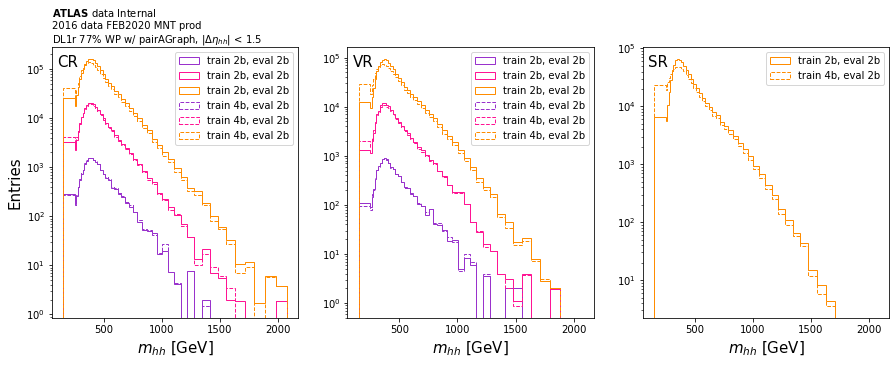

In [44]:
density = False
log=True

fig, axes = plt.subplots(1,3, figsize=(15,5))

for r,region,ax in zip([2,1,0], ['CR','VR','SR'],axes):
    for ntag_tr, ls in zip([2,4],['-','--']): # '--',

        if r > 0:
            # 4b 
            df_odd  = dat_dfs[f'{ntag_tr}b_tr_odd_3b_eval']
            df_even = dat_dfs[f'{ntag_tr}b_tr_odd_3b_eval']

            m_odd  = (df_odd.kinematic_region ==r) & (np.abs(df_odd.eta_h1  - df_odd.eta_h2 ) < 1.5)
            m_even = (df_even.kinematic_region==r) & (np.abs(df_even.eta_h1 - df_even.eta_h2) < 1.5)

            mhh  = np.hstack([df_odd.loc[ m_odd  & (df_odd.ntag >=4), 'm_hh'],
                              df_even.loc[m_even & (df_even.ntag>=4),'m_hh']])
            prob = np.hstack([df_odd.loc[ m_odd  & (df_odd.ntag >=4), 'max_prob'],
                              df_even.loc[m_even & (df_even.ntag >=4),'max_prob']])


            ax.hist(mhh,edges,color='darkorchid',label=f'train {ntag_tr}b, eval 2b',
                    ls=ls,histtype='step',density=density,log=log,weights=prob)


            # 3b
            mhh = np.hstack([df_odd.loc[ m_odd   & (df_odd.ntag ==3),'m_hh'],
                             df_even.loc[m_even  & (df_even.ntag==3),'m_hh']])
            prob = np.hstack([df_odd.loc[ m_odd  & (df_odd.ntag ==3),'max_prob'],
                              df_even.loc[m_even & (df_even.ntag==3),'max_prob']])

            ax.hist(mhh,edges,color='deeppink',label=f'train {ntag_tr}b, eval 2b',
                    ls=ls,histtype='step',density=density,log=log,weights=prob)


        # 2b
        df_odd  = dat_dfs[f'{ntag_tr}b_tr_odd_2b_eval']
        df_even = dat_dfs[f'{ntag_tr}b_tr_odd_2b_eval']

        m_odd  = (df_odd.kinematic_region ==r) & (np.abs(df_odd.eta_h1  - df_odd.eta_h2 ) < 1.5)
        m_even = (df_even.kinematic_region==r) & (np.abs(df_even.eta_h1 - df_even.eta_h2) < 1.5)


        mhh = np.hstack([df_odd.loc[ m_odd, 'm_hh'],
                         df_even.loc[m_even,'m_hh']])
        prob = np.hstack([df_odd.loc[ m_odd,'max_prob'],
                          df_even.loc[m_even,'max_prob']])

        ax.hist(mhh,edges,color='darkorange',label=f'train {ntag_tr}b, eval 2b',
                ls=ls,histtype='step',density=density,log=log,weights=prob)

    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=15)
    ax.legend()
    ax.text(0.02,0.97,region,fontsize=15,transform=ax.transAxes,ha='left',va='top')

axes[0].set_ylabel('Entries',fontsize=15)
axes[0].text(0,1,dataText,transform=axes[0].transAxes,ha='left',va='bottom')

plt.savefig('figures/data16_PFlow-FEB20-5jets/mhh_SMtrain_CR_VR_SR.pdf',
            bbox_inches='tight')
plt.show()

Ok, so for training with 2b, I *do* have more entries in the lowest $m_{hh}$ bin, which was what Michael was expecting, but since I couldn't get the reweighting to work w/o 2b included in the training, I think I should *dial back* and try to get pseudo-tagging to work first before deciding what decision to make.

**Diagnosis**

To understand *why* this is, I want to look at the truth $m_{hh}$ distribution for each b-tag requirement.

In [46]:
prodTag = 'APR2020'
nSelectedJets = 5

smDir = f'SMNR_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'
sdf  = pd.read_hdf(f"../data/{smDir}/df_2b_scaledInputs.h5", key='df')

In [48]:
smText = "$\mathbf{ATLAS}$ data Internal\n"
smText += "SM ggF NLO FT, APR2020 MNT prod\n"
smText += "DL1r 77% WP w/ pairAGraph"

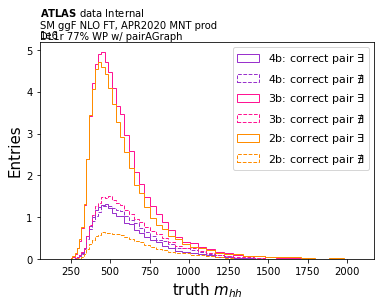

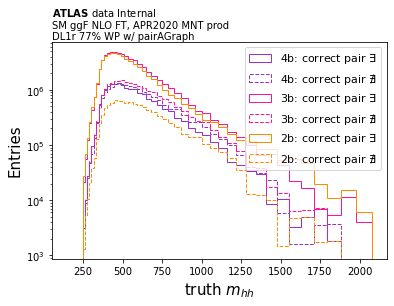

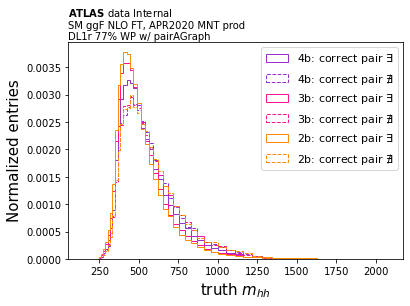

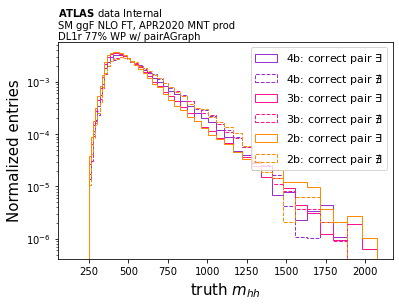

In [50]:
for density, ylabel in zip([False,True],['Entries','Normalized entries']):

    for log in [False,True]:
        
        for ntag, c in zip([4,3,2],['darkorchid','deeppink','darkorange']):

            bmask = (sdf.ntag == 4) if (ntag == 4) else (sdf.ntag==ntag)

            plt.hist(sdf.loc[bmask &  sdf.correctPair,'truth_mhh'], edges, color=c, log=log,
                     label=f'{ntag}b: correct pair $\exists$', histtype='step',density=density,
                     weights=sdf.loc[bmask &  sdf.correctPair,'truth_mhh'])

            plt.hist(sdf.loc[bmask & ~sdf.correctPair,'truth_mhh'], edges, color=c, log=log, ls='--',
                     label=f'{ntag}b: '+r'correct pair $\nexists$', histtype='step',density=density,
                     weights=sdf.loc[bmask & ~sdf.correctPair,'truth_mhh'])

        plt.legend(fontsize=11)
        plt.xlabel('truth $m_{hh}$',fontsize=15)
        plt.ylabel(ylabel,fontsize=15)
        
        ax = plt.gca()
        ax.text(0,1,smText,transform=ax.transAxes,ha='left',va='bottom')
        normTag = '_norm' if density else ''
        logTag  = '_log'  if log     else ''
        plt.savefig(f'figures/SMNR_mc16a_PFlow-APR2020-5jets/truth_mhh{normTag}{logTag}_234b.pdf',
                    bbox_inches='tight')
        plt.show()
    

**Lessons:** 
- The trainings on 3b and 2b are *completely overwhelmed* by the lower tag data.
- However, the 4-tag spectrum *seems* to be harder, not softer, so it's not like including these events in the training is having a negative impact on the prior over $m_{hh}$ that we're learning.

**What should I do with this information?**
- Should I check how this evolves from the CR $\rightarrow$ SR? (Probably not - mostly the signal (should) be living in the SR.
- I could *downweight* the 2b events in the training if the pseudo-tagging doesn't work out.
- It will *also* be fun to look at a comparison between the correct and incorrect pairs and $m_{hh}$ and the massplanes c.f. the truth $m_{hh}$. (Yeah, but I *don't* think this would teach me anything new.)